
# Underdamped
Compare the EM scheme applied to the SDE, transformed SDE and rescaled time.  

In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)


import time as time

# -------------- SET UP YOUR PATH ------------
import sys
# sys.path.append("~/OneDrive/ExtendedProject/Code/Weak SDE approximation/C++")
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
%matplotlib inline
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 17}

# matplotlib.rc('font', **font)
import pandas as pd
import scipy.integrate as integrate
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Define useful functions 

In [2]:
def look_at_final(df):
    # df = pd.DataFrame(df,columns=["sim","t","Q","P","g"])
    #Create a dataset with only the final time
    idx = df.groupby(['sim'])['t'].transform(max) == df['t'] #Get the indexes of the final time
    final_df=df[idx] #Select only dataset with final time
    qf_list,pf_list,gpf_list,tf_list,g_list = np.array(final_df["q"]), np.array(final_df["p"]), np.array(final_df["gp"]), np.array(final_df["t"]), np.array(final_df["g"])
    return(qf_list,pf_list,gpf_list,tf_list,g_list)

def plot_evolving(df_noada,df_rescale,df_transfo):

    list_step=df_noada['count'].unique()
    ## Set up the plots 
    fig, ((axs))= plt.subplots(2,len(list_step),figsize=(25,10))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    fig.suptitle('underdamped-evolving distributions M='+str(M)+', m=' +str(m)+", $\gamma=$"+str(gamma)+", $\\tau$="+str(tau), fontsize=25)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    b_p=3 #bounds for p distr
    b_q=2.5
    ## Loop through the values 
    for i in range(len(list_step)):
        
        # List of time
        counti = list_step[i]

        ### NOT ADAPTIVE
        df_noada_i=df_noada[df_noada['count']==counti]
        # --- No ada
        histogram,bins = np.histogram(df_noada_i["q"],bins=100,range=[0,b_q], density=True)
        midx_q = (bins[0:-1]+bins[1:])/2
        axs[0,i].plot(midx_q,histogram,label='SDE',color="red")
        
        histogram,bins = np.histogram(df_noada_i["p"],bins=100,range=[-b_p,b_p], density=True)
        midx_p = (bins[0:-1]+bins[1:])/2
        axs[1,i].plot(midx_p,histogram,label='SDE',color="red")
        
    
        # --- Transformed SDE
        df_transfo_i=df_transfo[df_transfo['count']==counti]
        histogram,bins = np.histogram(df_transfo_i["q"],bins=100,range=[0,b_q], density=True)
        midx_q = (bins[0:-1]+bins[1:])/2
        axs[0,i].plot(midx_q,histogram,label='transformed SDE',color="green")

        histogram,bins = np.histogram(df_transfo_i["p"],bins=100,range=[-b_p,b_p], density=True)
        midx_p = (bins[0:-1]+bins[1:])/2
        axs[1,i].plot(midx_p,histogram,label='transformed SDE',color="green")


        # --- Rescaled time
        df_rescale_i=df_rescale[df_rescale['count']==counti]
        histogram,bins = np.histogram(df_rescale_i["q"],bins=100,range=[0,b_q], density=True)
        midx_q = (bins[0:-1]+bins[1:])/2
        axs[0,i].plot(midx_q,histogram,label='rescaled time',color="blue")
        axs[0,i].set_ylabel("Q")

        histogram,bins = np.histogram(df_rescale_i["p"],bins=100,range=[-b_p,b_p], density=True)
        midx_p = (bins[0:-1]+bins[1:])/2
        axs[1,i].plot(midx_p,histogram,label='rescaled time',color="blue")
        axs[1,i].set_ylabel("P")

        # --- P invariant
        rho = np.exp(- (midx_p**2)/(2*tau))
        rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
        axs[1,i].plot(midx_p,rho,'--',label='Truth',color="orange")

        # --- Q invariant
        rho = np.exp(- U(midx_q)/tau)
        rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
        axs[0,i].plot(midx_q,rho,'--',label='invariant',color="orange")

        axs[0,i].set_title("steps="+str(np.round(Ntl[i],0)),fontsize= 20)

        # parameters of axis
        axs[0,i].set_ylim([0, 4])
        axs[1,i].set_ylim([0, 1.5])



    axs[0,len(list_step)-1].legend(loc='lower center',bbox_to_anchor=(-5, 1.06),
            ncol=5, fancybox=True, shadow=True)


    fig.savefig('evolving_distrM'+str(M)+"m"+str(m)+"Nt"+str(500)+"h"+str(h)+"tau"+str(tau)+".png")

def plot_distr_Tfgpgdt(df_rescale,df_transfo):
    qf_list,pf_list,gpf_list,tf_list,gdt_list = look_at_final(df_rescale)

    ## Set up the plots 
    fig, ((ax1,ax2,ax3))= plt.subplots(1,3,figsize=(10,5))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    # fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    var = tf_list
    lowerbound=np.min(var)
    upperbound=np.max(var)
    nbins=100
    histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    ax1.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="blue",label="Rescaled",alpha=0.5)
    # ax1.set_ylim([0,0.8])
    ax1.set_title("Final time reached with EM applied \nto SDE with rescaled time", fontsize=15)
    ax1.set_ylabel("$T_f$")

    qf_list,pf_list,gpf_list,tf_list,g_list = look_at_final(df_transfo)

    var = gpf_list
    lowerbound=np.min(var)
    upperbound=np.max(var)
    nbins=100
    histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    ax2.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="blue",label="transformed",alpha=0.5)
    # ax2.set_ylim([0,1])
    ax2.set_ylabel("$g'(x)$")
    ax2.set_title("$g'(x)$", fontsize=15)

    qf_list,pf_list,gpf_list,tf_list,g_list = look_at_final(df_transfo)

    var = g_list
    lowerbound=np.min(var)
    upperbound=np.max(var)
    nbins=100
    histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    ax3.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="blue",label="trasnformed",alpha=0.5)
    # ax3.set_ylim([0,300])
    ax3.set_ylabel("$g(x)$")
    ax3.set_title("$g(x)$", fontsize=15)

    qf_list,pf_list,gpf_list,tf_list,g_list = look_at_final(df_rescale)

    var = g_list
    lowerbound=np.min(var)
    upperbound=np.max(var)
    nbins=100
    histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    ax3.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="red",label="rescale",alpha=0.5)
    ax3.legend(loc='lower center',bbox_to_anchor=(-5, 1.06),
            ncol=1, fancybox=True, shadow=True)

def plot_distr_Tfgpgdt(df_rescale,df_transfo):
    qf_list,pf_list,gpf_list,tf_list,gdt_list = look_at_final(df_rescale)

    ## Set up the plots 
    fig, ((ax1,ax2,ax3))= plt.subplots(1,3,figsize=(10,5))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    # fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    var = tf_list
    lowerbound=np.min(var)
    upperbound=np.max(var)
    nbins=100
    histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    ax1.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="red",label="Rescaled",alpha=0.5)
    ax1.set_ylabel("$T_f$")


    qf_list,pf_list,gpf_list,tf_list,g_list = look_at_final(df_transfo)
    var = g_list
    lowerbound=np.min(var)
    upperbound=np.max(var)
    nbins=100
    histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    ax2.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="blue",label="transformed",alpha=0.5)
    ax2.set_ylabel("$g(x)$")

    spacing = 0.5
    minorLocator = MultipleLocator(spacing)
    # Set minor tick locations.
    ax2.yaxis.set_minor_locator(minorLocator)
    ax2.xaxis.set_minor_locator(minorLocator)
    # Set grid to use minor tick locations. 
    ax2.grid(which = 'minor')

    
    qf_list,pf_list,gpf_list,tf_list,g_list = look_at_final(df_rescale)
    var = g_list
    lowerbound=np.min(var)
    upperbound=np.max(var)
    nbins=100
    histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    ax2.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="red",label="rescaled",alpha=0.5)
    ax2.legend(loc='lower center',bbox_to_anchor=(2, 1.06),
            ncol=1, fancybox=True, shadow=True)

    qf_list,pf_list,gpf_list,tf_list,g_list = look_at_final(df_transfo)
    var = gpf_list
    lowerbound=np.min(var)
    upperbound=np.max(var)
    nbins=100
    histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
    midx = (bins[0:-1]+bins[1:])/2
    ax3.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="blue",label="Transformed",alpha=0.5)
    ax3.set_ylabel("$g'(x)$")

def look_final_distr(df_noada,df_rescale,df_transfo):
    fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
    fig.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)

    fig.suptitle("$\\beta$="+str(tau)+", $\\gamma=$"+str(gamma))

    # No ada 
    qf_list,pf_list,gpf_list,tf_list,gdt_list = look_at_final(df_noada)
    ## p
    histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    ax1.plot(midx_q,histogram,label='sde',color="red")
    ## q 
    histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    ax2.plot(midx_p,histogram,label='sde',color="red")

    # Ada transfo 
    qf_list,pf_list,gpf_list,tf_list,gdt_list = look_at_final(df_transfo)
    ## p
    histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    ax1.plot(midx_q,histogram,label='transformed sde',color="green")
    ## q 
    histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    ax2.plot(midx_p,histogram,label='transformed sde',color="green")

    # Rescale 
    qf_list,pf_list,gpf_list,tf_list,gdt_list = look_at_final(df_rescale)
    ## p
    histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    ax1.plot(midx_q,histogram,label='rescaled',color="blue")
    ## q 
    histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    ax2.plot(midx_p,histogram,label='rescaled',color="blue")

    ### position q invariant
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    ax1.plot(midx_q,rho,'--',label='invariant',color="orange")
    #ax1.legend() 

    ### momentum p invariant
    rho = np.exp(-(midx_p**2)/(2*tau))
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    ax2.plot(midx_p,rho,'--',label='invariant',color="orange")

    ax2.legend(loc='lower center',bbox_to_anchor=(-0.4, -.25),
            ncol=4, fancybox=True, shadow=True)


## Define code to generate samples

### Using the gradient

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
##############################
# Define some global variables
##############################
M=10
m=0.1
# include_ada = 2 #if 1 make the code adaptive 
printskip=100
Ntl = np.array([51,101,502,1002,2000,3500,4000,5000])
lenNtl = len(Ntl)


def U(x):
    res = (0.5/(x*x)+x*x)
    return res


@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    g = 2*g #I think gprime should be larger to actually work 
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    gprime= 2*gprime #I think gprime should be larger to actually work 
    return gprime

@njit(float64[:,:](float64[:],float64,float64,float64,float64,int32))
def one_traj_adaNTest(qp,Nt,dt,gamma,tau,include_ada):
    t=0
    q=qp[0]
    p=qp[1]

    #set up vectors to save results 
    size_save = int(lenNtl) #int(Nt/printskip)
    tqpg_list = np.zeros((size_save,5))
    save_i=0 

    #useful things to compute for first step
    f = -Up(q)
    g=1
    if include_ada==1:     #Transformed SDE
        g=getg(q)
        gp=getgprime(q)
    elif include_ada==2:     # Rescaled SDE
        g=getg(q)

    gdt=g*dt

    for count in range(Nt):

        #**********
        #* STEP B *
        #**********
        p +=0.5*gdt*f 
            # Transformed SDE: step B with extra term in it
        if include_ada==1:
            p += 0.5*dt*tau*gp

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP O *
        #**********
        dB = np.random.normal(0,1)
        C =np.exp(-gdt*gamma) 
        p = C*p+ np.sqrt((1-C*C)*tau)*dB

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP B *
        #**********
        # Need to compute new quantities for f and g 
        f = -Up(q)
        g=1                    # Normal SDE                
        if include_ada==1:     # Transformed SDE
            g=getg(q)
            gp=getgprime(q)
        elif include_ada==2:   # Rescaled SDE
            g=getg(q)
    
        gdt=g*dt

        p +=0.5*gdt*f 
            # Transformed SDE: step B with extra term in it
        if include_ada==1:
            p += 0.5*dt*tau*gp

        #*********************************
        #* Save (p,q) and update time and*
        #*********************************
        if count==Ntl[save_i]:
            tqpg_list[save_i,0]=t
            tqpg_list[save_i,1]=q
            tqpg_list[save_i,2]=p
            if include_ada==1:
                tqpg_list[save_i,3]=gp
            else:
                tqpg_list[save_i,3]=0
            tqpg_list[save_i,4]=g
            save_i+=1
        
        #* change the clock for the transformed SDE, move time forward using gdt.
        #* resulting in using gdt for all schemes
        #***********************************************************************
        if include_ada==0:
            t+=dt
        else:
            t+=gdt

    return(tqpg_list)

@njit(parallel=True)
def method_baoab_ada(n_samples,gamma,tau,Nt,h,include_ada):
    nsample_pertraj = int(lenNtl)
    tqpg_list=np.zeros((n_samples*nsample_pertraj,6))
    ones_nsample=np.ones(nsample_pertraj)
    for j in nb.prange(n_samples):
        qi = np.random.uniform(0.5, 5) #np.abs(np.random.normal(0,1,2)) #initial conditions np.array([2.0,0.0]) 
        pi= np.random.normal(0,1)
        qipi=np.array([qi,pi])
        qp_samples = one_traj_adaNTest(qipi,Nt,h,gamma,tau,include_ada)
        start_i = nsample_pertraj*j
        end_i = nsample_pertraj*(j+1)
        tqpg_list[start_i:end_i,1:6]=qp_samples
        tqpg_list[start_i:end_i,0]=ones_nsample*j
    return(tqpg_list)

#compile the method
test = method_baoab_ada(1,0.1,0.1,1,0.1,0)

### Use the hessian rather than the gradient 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
##############################
# Define some global variables
##############################
M=10
m=0.1
Ntl = np.array([51,101,502,1002,2000,3500,4000,5000])
# Ntl = np.array([100000]) #for more steps 

lenNtl = len(Ntl)

def U(x):
    res = (0.5/(x*x)+x*x)
    return res


@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

@njit(float64(float64))
def getg2(x): #,dtmin, dtmax, R):
    x6 = np.power(x,-6)
    xi = np.sqrt(m*m+x6)
    g=(1./M+1./xi)
    return g

@njit(float64(float64))
def getgprime2(x):
    x6 = np.power(x,-6)
    xi = np.sqrt(m*m+x6)
    x7=x6/x
    xi = np.sqrt(x6+m*m);
    gprime= 3*x7/np.power(xi,3)
    return gprime

@njit(float64[:,:](float64[:],float64,float64,float64,float64,int32))
def one_traj_ada2(qp,Nt,dt,gamma,tau,include_ada):
    t=0
    q=qp[0]
    p=qp[1]


    #set up vectors to save results 
    size_save = int(lenNtl) #int(Nt/printskip)
    tqpg_list = np.zeros((size_save,5))
    save_i=0 

    #useful things to compute for first step
    f = -Up(q)
    g=1
    if include_ada==1:     #Transformed SDE
        g=getg2(q)
        gp=getgprime2(q)
    elif include_ada==2:     # Rescaled SDE
        g=getg2(q)

    gdt=g*dt

    for count in range(Nt):

        
        #**********
        #* STEP B *
        #**********
        p +=0.5*gdt*f 
            # Transformed SDE: step B with extra term in it
        if include_ada==1:
            p += 0.5*dt*tau*gp

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP O *
        #**********
        dB = np.random.normal(0,1)
        C =np.exp(-gdt*gamma) 
        p = C*p+ np.sqrt((1-C*C)*tau)*dB

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP B *
        #**********
        # Need to compute new quantities for f and g 
        f = -Up(q)
        g=1                    # Normal SDE                
        if include_ada==1:     # Transformed SDE
            g=getg2(q)
            gp=getgprime2(q)
        elif include_ada==2:   # Rescaled SDE
            g=getg2(q)
    
        gdt=g*dt

        p +=0.5*gdt*f 
            # Transformed SDE: step B with extra term in it
        if include_ada==1:
            p += 0.5*dt*tau*gp

        #*********************************
        #* Save (p,q) and update time and*
        #*********************************
        if count==Ntl[save_i]:
            tqpg_list[save_i,0]=t
            tqpg_list[save_i,1]=q
            tqpg_list[save_i,2]=p
            if include_ada==1:
                tqpg_list[save_i,3]=gp
            else:
                tqpg_list[save_i,3]=0
            tqpg_list[save_i,4]=g
            save_i+=1
            
        if include_ada==1: # in the case of transformed move time forward using dt
            t+= dt 
        else:              # in the case of rescaled (time moved using gdt) and normal em (time moved forward using gdt=1*dt)
            t+=gdt
    return(tqpg_list)

@njit(parallel=True)
def method_baoab_ada2(n_samples,gamma,tau,Nt,h,include_ada):
    nsample_pertraj = int(lenNtl)
    tqpg_list=np.zeros((n_samples*nsample_pertraj,6))
    ones_nsample=np.ones(nsample_pertraj)
    for j in nb.prange(n_samples):
        qi = np.random.uniform(0.5, 5) #np.abs(np.random.normal(0,1,2)) #initial conditions np.array([2.0,0.0]) 
        pi= np.random.normal(0,1)
        qipi=np.array([qi,pi])
        qp_samples = one_traj_ada2(qipi,Nt,h,gamma,tau,include_ada)
        start_i = nsample_pertraj*j
        end_i = nsample_pertraj*(j+1)
        tqpg_list[start_i:end_i,1:6]=qp_samples
        tqpg_list[start_i:end_i,0]=ones_nsample*j
    return(tqpg_list)

#compile the method
qp = method_baoab_ada(2,0.1,1,10,0.1,2)

#### verify that the code works properly on underdamped

In [4]:
T=200
h = 0.1
gamma = 0.5
tau=0.1
n_samples=500000
Ntimes=int(T*1/h)+1
include_ada=0
qp_ada = method_baoab_ada(n_samples,gamma,tau,Ntimes,h,include_ada)


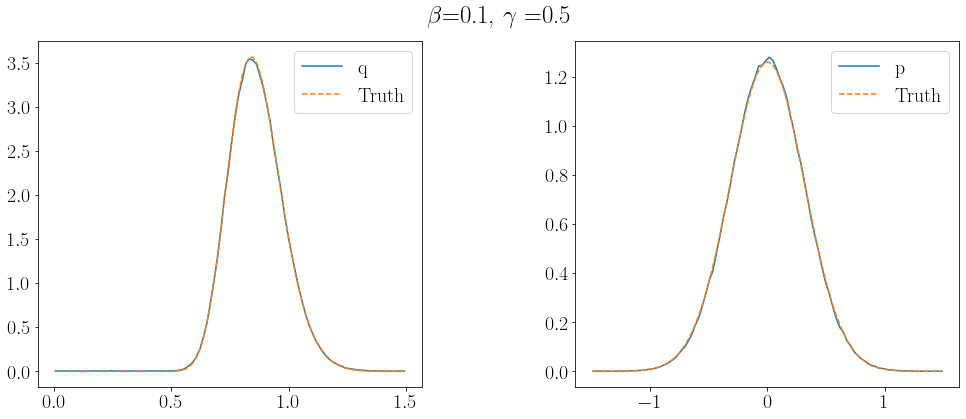

In [5]:
import pandas as pd
df = pd.DataFrame(qp_ada,columns=["sim","t","Q","P","gp","g"])
#Create a dataset with only the final time
idx = df.groupby(['sim'])['t'].transform(max) == df['t'] #Get the indexes of the final time
final_df=df[idx] #Select only dataset with final time
#Get numpy arrays of the final values 
qf_list,pf_list,gf_list,tf_list = np.array(final_df["Q"]), np.array(final_df["P"]), np.array(final_df["gp"]), np.array(final_df["t"])

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

fig.suptitle("$\\beta$="+str(tau)+", $\\gamma=$"+str(gamma))

#Plot 1
## position q experiment - C CODE
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='q')
ax1.legend() 

#Plot 2: 
### momentum p experiment NUMBA CODE
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
# histogram=(histogram/np.sum(histogram)*(midx[1]-midx[0]) )
ax2.plot(midx_p,histogram,label='p')

### position q true
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
ax1.plot(midx_q,rho,'--',label='Truth')
ax1.legend() 

### momentum p true
rho = np.exp(-(midx_p**2)/(2*tau))
rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
ax2.plot(midx_p,rho,'--',label='Truth')
ax2.legend() 

## Fixed steps
### Using gradient as g(x)

In [4]:
T=100
h = 0.01
gamma = 0.5
tau=0.1
n_samples=100000
Nt=5001

# if include_ada==0 No adaptivity 
include_ada=0   
%time pq_noada= method_baoab_ada(n_samples,gamma,tau,Nt,h,include_ada)
df_noada = pd.DataFrame(pq_noada,columns=["sim","t","q","p","gp","g"])
df_noada['count'] = df_noada.groupby(['sim']).cumcount()+1

# if include_ada==1 EM applied to transformed SDE and steps using t+=dt  
include_ada=1
%time pq_transfo= method_baoab_ada(n_samples,gamma,tau,Nt,h,include_ada)
df_transfo = pd.DataFrame(pq_transfo,columns=["sim","t","q","p","gp","g"])
df_transfo['count'] = df_transfo.groupby(['sim']).cumcount()+1

# if include_ada==2 EM applied to non transformed SDE but rescale steps t+=gdt
include_ada=2
%time pq_rescale= method_baoab_ada(n_samples,gamma,tau,Nt,h,include_ada)
df_rescale = pd.DataFrame(pq_rescale,columns=["sim","t","q","p","gp","g"])
df_rescale['count'] = df_rescale.groupby(['sim']).cumcount()+1


CPU times: user 32.9 s, sys: 65.5 ms, total: 33 s
Wall time: 3.15 s
CPU times: user 1min 37s, sys: 307 ms, total: 1min 37s
Wall time: 9.38 s
CPU times: user 1min 47s, sys: 270 ms, total: 1min 48s
Wall time: 10.7 s


NameError: name 'plot_evolving' is not defined

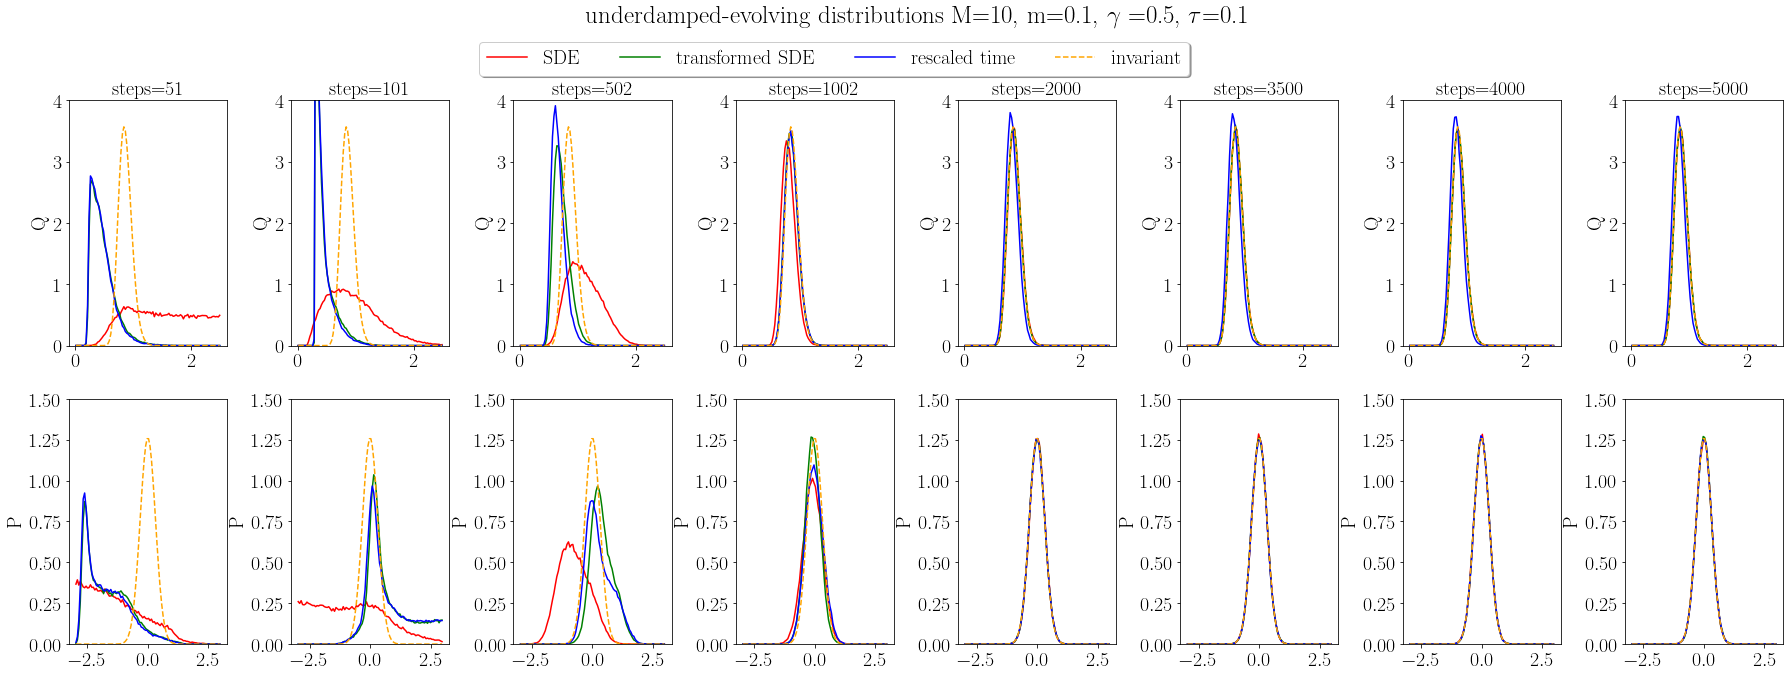

In [8]:
plot_evolving(df_noada,df_rescale,df_transfo)

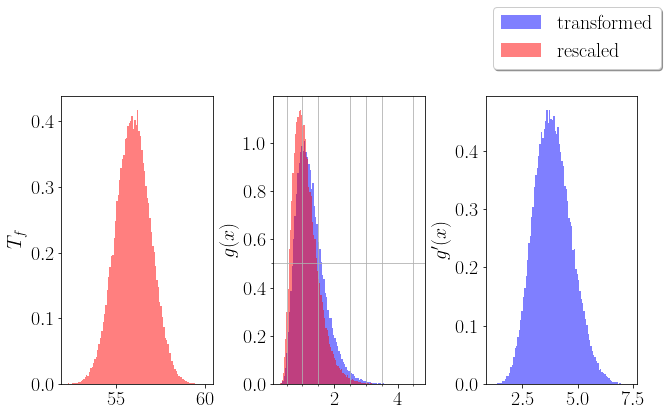

In [6]:
plot_distr_Tfgpgdt(df_rescale,df_transfo)

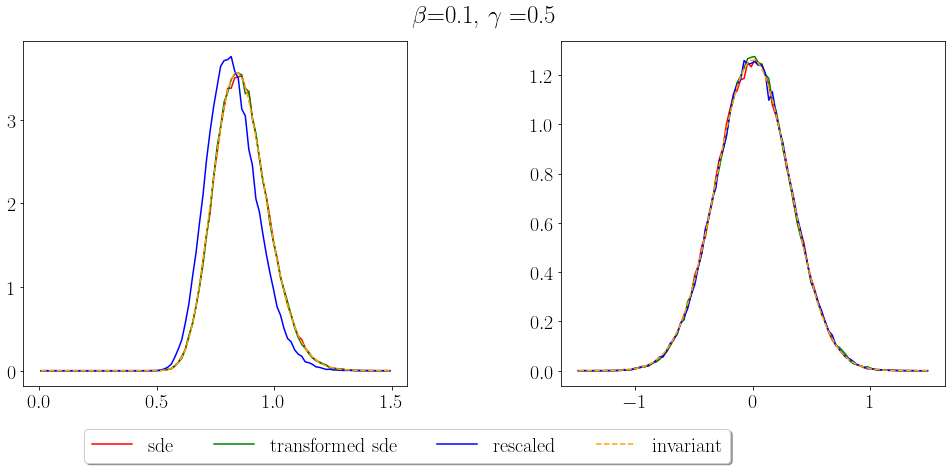

In [7]:
look_final_distr(df_noada,df_rescale,df_transfo)

### Using hessian as g(x)

CPU times: user 37.1 s, sys: 263 ms, total: 37.3 s
Wall time: 5.13 s
CPU times: user 2min 16s, sys: 211 ms, total: 2min 16s
Wall time: 12.4 s
CPU times: user 1min 42s, sys: 136 ms, total: 1min 43s
Wall time: 9.77 s


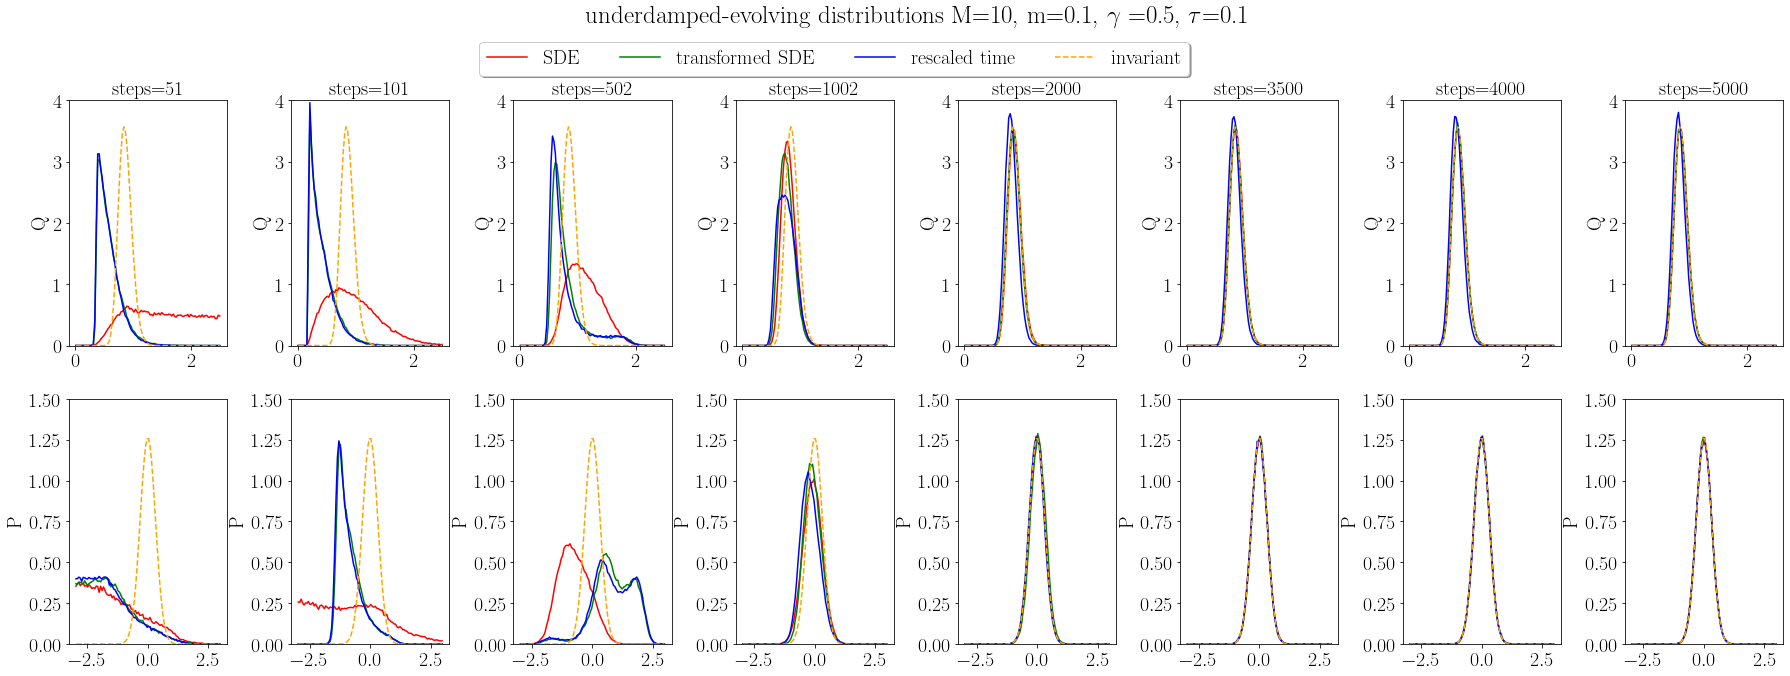

In [11]:
T=100
h = 0.01
gamma = 0.5
tau=0.1
n_samples=100000
Nt=5001

# if include_ada==0 No adaptivity 
include_ada=0   
%time pq_noada2= method_baoab_ada2(n_samples,gamma,tau,Nt,h,include_ada)
df_noada2 = pd.DataFrame(pq_noada2,columns=["sim","t","q","p","gp","g"])
df_noada2['count'] = df_noada2.groupby(['sim']).cumcount()+1

# if include_ada==1 EM applied to transformed SDE and steps using t+=dt  
include_ada=1
%time pq_transfo2= method_baoab_ada2(n_samples,gamma,tau,Nt,h,include_ada)
df_transfo2 = pd.DataFrame(pq_transfo2,columns=["sim","t","q","p","gp","g"])
df_transfo2['count'] = df_transfo2.groupby(['sim']).cumcount()+1

# if include_ada==2 EM applied to non transformed SDE but rescale steps t+=gdt
include_ada=2
%time pq_rescale2= method_baoab_ada2(n_samples,gamma,tau,Nt,h,include_ada)
df_rescale2 = pd.DataFrame(pq_rescale2,columns=["sim","t","q","p","gp","g"])
df_rescale2['count'] = df_rescale2.groupby(['sim']).cumcount()+1

plot_evolving(df_noada2,df_rescale2,df_transfo2)

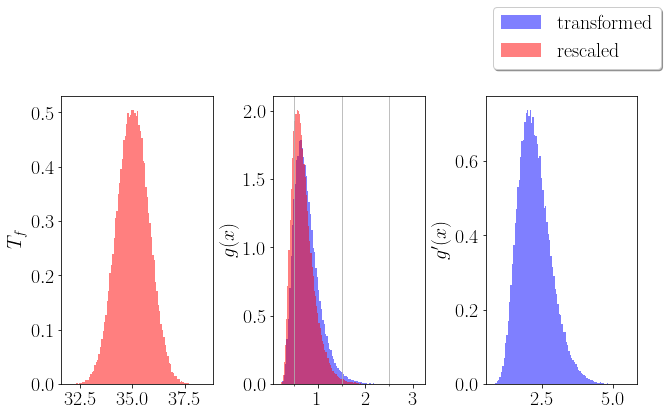

In [12]:
plot_distr_Tfgpgdt(df_rescale2,df_transfo2)

#### Bias after Nsteps

In [13]:
T=1000
h = 0.01
gamma = 0.5
tau=0.1
n_samples=100000
Nt=int(T*1/h)+1
print(Nt)

# if include_ada==2 EM applied to non transformed SDE but rescale steps t+=gdt
include_ada=2
%time pq_rescaled_moresteps= method_baoab_ada(n_samples,gamma,tau,Nt,h,include_ada)

100001
CPU times: user 33min 40s, sys: 2.17 s, total: 33min 42s
Wall time: 2min 56s


In [14]:
df_moresteps = pd.DataFrame(pq_rescaled_moresteps,columns=["sim","t","q","p","gp","g"])

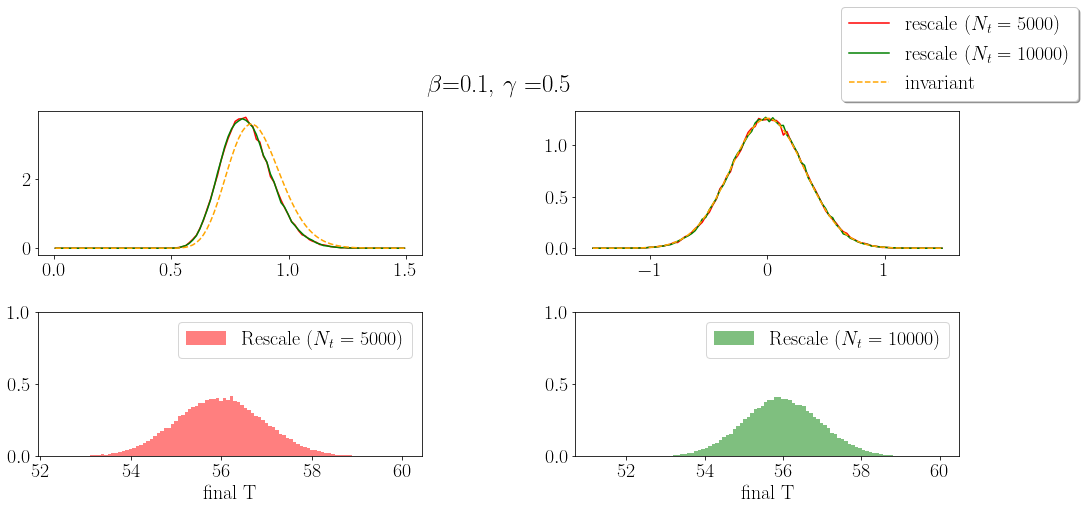

In [15]:

fig, ((ax1,ax2),(ax3,ax4))= plt.subplots(2, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

fig.suptitle("$\\beta$="+str(tau)+", $\\gamma=$"+str(gamma))

# Rescaled with Nt=10000 
qf_list,pf_list,gpf_list,tf_list,g_list =look_at_final(df_rescale)
## p
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='rescale ($N_t=5000$)',color="red")
## q 
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,label='rescale ($N_t=5000$)',color="red")

## t
var = tf_list
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax3.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="red",label="Rescale ($N_t=5000$)",alpha=0.5)
ax3.set_ylim([0,1])
ax3.set_xlabel("final T")
ax3.legend()

# Rescaled with Nt=100000 
qf_list,pf_list,gpf_list,tf_list,g_list =look_at_final(df_moresteps)
## p
histogram,bins = np.histogram(qf_list,bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='rescale ($N_t=10 000$) sde',color="green")
## q 
histogram,bins = np.histogram(pf_list,bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,label='rescale ($N_t=10 000$)',color="green")
## t 
var = tf_list
lowerbound=np.min(var)
upperbound=np.max(var)
nbins=100
histogram,bins = np.histogram(var,bins=nbins,range=[lowerbound,upperbound], density=True)
midx = (bins[0:-1]+bins[1:])/2
ax4.bar(midx,histogram,width=(upperbound-lowerbound)/nbins,color="green",label="Rescale ($N_t=10 000$)",alpha=0.5)
ax4.set_ylim([0,1])
ax4.set_xlabel("final T")
ax4.legend()

### position q invariant
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
ax1.plot(midx_q,rho,'--',label='invariant',color="orange")
#ax1.legend() 

### momentum p invariant
rho = np.exp(-(midx_p**2)/(2*tau))
rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
ax2.plot(midx_p,rho,'--',label='invariant',color="orange")

ax2.legend(loc='lower center',bbox_to_anchor=( 1, 1),
          ncol=1, fancybox=True, shadow=True)



list_time_rescale=df_rescale[df_rescale['count']==6]['t']



## Fixed time



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
##############################
# Define some global variables
##############################
M=10
m=0.1
# include_ada = 2 #if 1 make the code adaptive 
printskip=100
Tl = np.array([0.5,1,5,10,50,99])
lenTl = len(Tl)
def U(x):
    res = (0.5/(x*x)+x*x)
    return res


@njit(float64(float64))
def Up(x):
    res = -1/(x*x*x)+2*x
    return res

@njit(float64(float64))
def getg(x): #,dtmin, dtmax, R):
    x6 = np.power(x,6)
    xi = np.sqrt(m*m+x6)
    g=1./(1./M+1./xi)
    g=2*g
    return g

@njit(float64(float64))
def getgprime(x):
    x6 = np.power(x,6);
    x5 = x6/x
    xi = np.sqrt(x6+m*m);
    g =1./(1./M + 1./xi);
    gprime= 3*x5*np.power(g,2)/np.power(xi,3)
    gprime=2*gprime
    return gprime

@njit(float64[:,:](float64[:],float64,float64,float64,float64,int32))
def one_traj_ada(qp,T,dt,gamma,tau,include_ada):
    t=0
    q=qp[0]
    p=qp[1]

    #useful things to compute for first step
    f = -Up(q)
    g=1
    if include_ada==1:     #Transformed SDE
        g=getg(q)
        gp=getgprime(q)
    elif include_ada==2:     # Rescaled SDE
         g=getg(q)
        
    
    gdt=g*dt

    #set up vectors to save results 
    size_save = int(lenTl)*10 #int(Nt/printskip)
    tqpg_list = np.zeros((size_save,4))
    save_i=0 
    step=0


    while t<T:
        step+=1

        #**********
        #* STEP B *
        #**********
        p +=0.5*gdt*f 
            # Transformed SDE: step B with extra term in it
        if include_ada==1:
            p += 0.5*dt*tau*gp

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP O *
        #**********
        dB = np.random.normal(0,1)
        C =np.exp(-gdt*gamma) 
        p = C*p+ np.sqrt((1-C*C)*tau)*dB

        #**********
        #* STEP A *
        #**********
        q += 0.5*gdt*p

        #**********
        #* STEP B *
        #**********
        # Need to compute new quantities for f and g 
        f = -Up(q)
        g=1                    # Normal SDE                
        if include_ada==1:     # Transformed SDE
            g=getg(q)
            gp=getgprime(q)
        elif include_ada==2:   # Rescaled SDE
            g=getg(q)
        gdt=g*dt
        
        p +=0.5*gdt*f 
            # Transformed SDE: step B with extra term in it
        if include_ada==1:
            p += 0.5*dt*tau*gp

        #*********************************
        #* Save (p,q) and update time and*
        #*********************************
        if t>Tl[save_i]:
            tqpg_list[save_i,0]=t
            tqpg_list[save_i,1]=q
            tqpg_list[save_i,2]=p
            tqpg_list[save_i,3]=step

            save_i+=1

        if include_ada==1: # in the case of transformed move time forward using dt
            t+= dt 
        else:              # in the case of rescaled (time moved using gdt) and normal em (time moved forward using gdt=1*dt)
            t+=gdt
    t = np.round(t,6)
    return(tqpg_list)

@njit(parallel=True)
def method_baoab_adaT(n_samples,gamma,tau,T,h,include_ada):
    nsample_pertraj = int(lenTl)*10
    tqpg_list=np.zeros((n_samples*nsample_pertraj,5))
    ones_nsample=np.ones(nsample_pertraj)
    for j in nb.prange(n_samples):
        qi = np.random.uniform(1, 3) #np.abs(np.random.normal(0,1,2)) #initial conditions np.array([2.0,0.0]) 
        pi= np.random.normal(0,1)
        qipi=np.array([qi,pi])
        qp_samples = one_traj_ada(qipi,T,h,gamma,tau,include_ada)
        start_i = nsample_pertraj*j
        end_i = nsample_pertraj*(j+1)
        tqpg_list[start_i:end_i,1:5]=qp_samples
        tqpg_list[start_i:end_i,0]=ones_nsample*j
    return(tqpg_list)

#compile the method
qp = method_baoab_adaT(2,0.1,0.1,10,0.1,0)

In [17]:
T=100
h = 0.01
gamma = 0.5
tau=0.1
n_samples=100000

# if include_ada==0 No adaptivity 
include_ada=0   
%time pq_noada= method_baoab_adaT(n_samples,gamma,tau,T,h,include_ada)
df_noada = pd.DataFrame(pq_noada,columns=["sim","t","q","p","step"])
df_noada=df_noada[df_noada['t']!=0]
df_noada['count'] = df_noada.groupby(['sim']).cumcount()+1

# if include_ada==1 EM applied to transformed SDE and steps using t+=dt  
include_ada=1
%time pq_transfo= method_baoab_adaT(n_samples,gamma,tau,T,h,include_ada)
df_transfo = pd.DataFrame(pq_transfo,columns=["sim","t","q","p","step"])
df_transfo=df_transfo[df_transfo['t']!=0]
df_transfo['count'] = df_transfo.groupby(['sim']).cumcount()+1

# if include_ada==2 EM applied to non transformed SDE but rescale steps t+=gdt
include_ada=2
%time pq_rescale= method_baoab_adaT(n_samples,gamma,tau,T,h,include_ada)
df_rescale = pd.DataFrame(pq_rescale,columns=["sim","t","q","p","step"])
df_rescale=df_rescale[df_rescale['t']!=0]
df_rescale['count'] = df_rescale.groupby(['sim']).cumcount()+1

CPU times: user 1min 6s, sys: 207 ms, total: 1min 7s
Wall time: 6.32 s
CPU times: user 4min 39s, sys: 554 ms, total: 4min 39s
Wall time: 27.6 s
CPU times: user 3min 12s, sys: 379 ms, total: 3min 12s
Wall time: 18.8 s


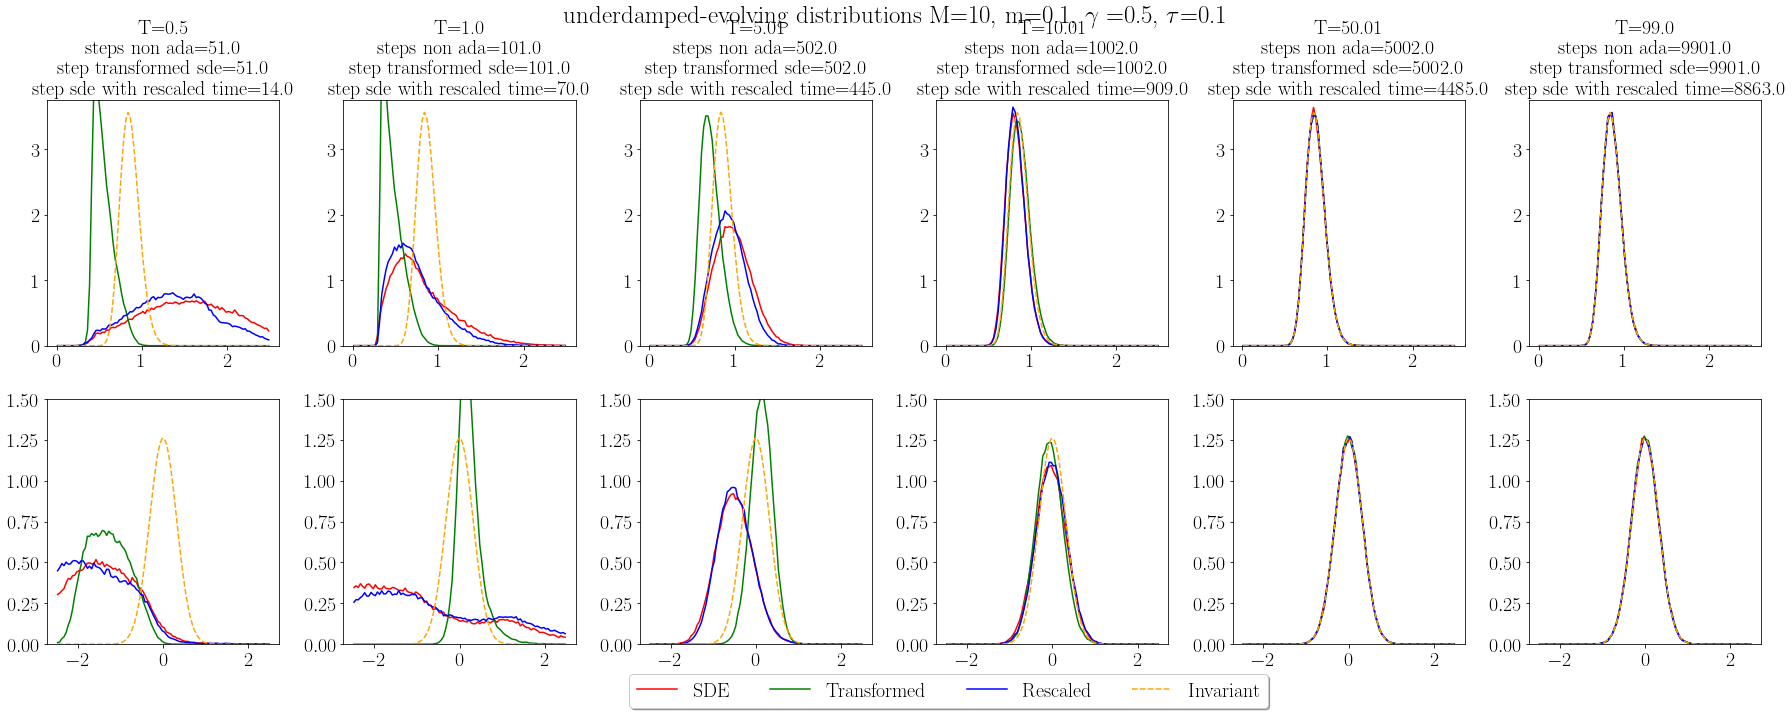

In [18]:
## Set up the plots 
list_count = df_rescale['count'].unique()
fig, ((axs))= plt.subplots(2,len(list_count),figsize=(25,10))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
fig.suptitle('underdamped-evolving distributions M='+str(M)+', m=' +str(m)+", $\gamma=$"+str(gamma)+", $\\tau$="+str(tau), fontsize=25)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
## Loop through the values 
for i in range(len(list_count)):
    
    # List of time
    counti = list_count[i]
    # * Dataframe 
    df_noada_i=df_noada[df_noada['count']==counti]

    # --- No ada
    histogram,bins = np.histogram(df_noada_i["q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='SDE',color="red")
    
    histogram,bins = np.histogram(df_noada_i["p"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='SDE',color="red")
    
   
    # --- Transformed SDE
    df_transfo_i=df_transfo[df_transfo['count']==counti]
    histogram,bins = np.histogram(df_transfo_i["q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='Transformed',color="green")

    histogram,bins = np.histogram(df_transfo_i["p"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='Transformed',color="green")


    # --- Rescaled time
        # * Dataframe 
    df_rescale_i=df_rescale[df_rescale['count']==counti]
    histogram,bins = np.histogram(df_rescale_i["q"],bins=100,range=[0,2.5], density=True)
    midx_q = (bins[0:-1]+bins[1:])/2
    axs[0,i].plot(midx_q,histogram,label='Rescaled',color="blue")
    
    histogram,bins = np.histogram(df_rescale_i["p"],bins=100,range=[-2.5,2.5], density=True)
    midx_p = (bins[0:-1]+bins[1:])/2
    axs[1,i].plot(midx_p,histogram,label='Rescaled',color="blue")

    # --- True
    # histogram,bins = np.histogram(df_ynoada_true_i["x"],bins=100,range=[0,2.5], density=True)
    # midx_q = (bins[0:-1]+bins[1:])/2
    # axs[i].plot(midx_q,histogram,"x",label='EM to non transformed SDE (small h)',color="magenta")

    # --- P invariant
    rho = np.exp(- (midx_p**2)/(2*tau))
    rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
    axs[1,i].plot(midx_p,rho,'--',label='Invariant',color="orange")

    # --- Q invariant
    rho = np.exp(- U(midx_q)/tau)
    rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
    axs[0,i].plot(midx_q,rho,'--',label='Invariant',color="orange")

    axs[0,i].set_title("t="+str(np.round(Tl[i],0)),fontsize= 20)

    # parameters of axis
    axs[0,i].set_ylim([0, 3.75])
    axs[1,i].set_ylim([0, 1.5])

    # non adaptive steps 
    titlei="T="+str(round(df_noada_i['t'].unique()[0],2))+"\n steps non ada="+str(df_noada_i['step'].unique()[0])+"\n step transformed sde="+str(df_transfo_i['step'].unique()[0])+"\n step sde with rescaled time="+str(np.round(df_rescale_i['step'].mean(),0))
    axs[0,i].set_title(titlei)


axs[1,len(list_count)-1].legend(loc='lower center',bbox_to_anchor=(-2.5, -.3), ncol=4, fancybox=True, shadow=True)


fig.savefig('evolving_distrM'+str(M)+"m"+str(m)+"Nt"+str(500)+"h"+str(h)+"tau"+str(tau)+".png")

### final distribution

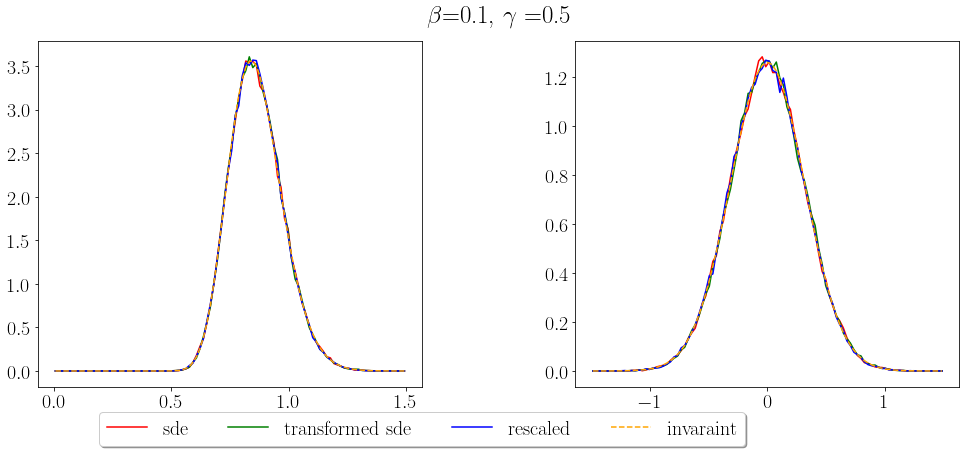

In [19]:

fig, (ax1,ax2)= plt.subplots(1, 2,figsize=(16,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)

fig.suptitle("$\\beta$="+str(tau)+", $\\gamma=$"+str(gamma))

# No ada 
idx = df_noada.groupby(['sim'])['t'].transform(max) == df_noada['t'] #Get the indexes of the final time
final_df=df_noada[idx] #Select only dataset with final time

## p
histogram,bins = np.histogram(final_df['q'],bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='sde',color="red")
## q 
histogram,bins = np.histogram(final_df['p'],bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,label='sde',color="red")

# Ada transfo 
idx = df_transfo.groupby(['sim'])['t'].transform(max) == df_transfo['t'] #Get the indexes of the final time
final_df=df_transfo[idx] #Select only dataset with final time
## p
histogram,bins = np.histogram(final_df['q'],bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='transformed sde',color="green")
## q 
histogram,bins = np.histogram(final_df['p'],bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,label='transformed sde',color="green")

# Rescale 
idx = df_rescale.groupby(['sim'])['t'].transform(max) == df_rescale['t'] #Get the indexes of the final time
final_df=df_rescale[idx] #Select only dataset with final time
## p
histogram,bins = np.histogram(final_df['q'],bins=100,range=[0,1.5], density=True)
midx_q = (bins[0:-1]+bins[1:])/2
ax1.plot(midx_q,histogram,label='rescaled',color="blue")
## q 
histogram,bins = np.histogram(final_df['p'],bins=100,range=[-1.5,1.5], density=True)
midx_p = (bins[0:-1]+bins[1:])/2
ax2.plot(midx_p,histogram,label='rescaled',color="blue")



### position q invariant
rho = np.exp(- U(midx_q)/tau)
rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
ax1.plot(midx_q,rho,'--',label='Invariant',color="orange")
#ax1.legend() 

### momentum p invariant
rho = np.exp(-(midx_p**2)/(2*tau))
rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
ax2.plot(midx_p,rho,'--',label='invaraint',color="orange")
ax2.legend(loc='lower center',bbox_to_anchor=(-.4, -.2),
           ncol=5, fancybox=True, shadow=True)


<!-- ## Approximate transient with transformed
### Fixed Steps -->

In [59]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.integrate as integrate
# from numba import jit,njit,vectorize, float64, int32
# import numba as nb
# import time as time
# ##############################
# # Define some global variables
# ##############################
# M=10
# m=0.1
# # include_ada = 2 #if 1 make the code adaptive 
# printskip=100
# Ntl = np.array([51,101,502,1002,2000,3500,4000,5000])
# lenNtl = len(Ntl)


# def U(x):
#     res = (0.5/(x*x)+x*x)
#     return res


# @njit(float64(float64))
# def Up(x):
#     res = -1/(x*x*x)+2*x
#     return res

# @njit(float64(float64))
# def getg(x): #,dtmin, dtmax, R):
#     x6 = np.power(x,6)
#     xi = np.sqrt(m*m+x6)
#     g=1./(1./M+1./xi)
#     g = 2*g #I think gprime should be larger to actually work 
#     return g

# @njit(float64(float64))
# def getgprime(x):
#     x6 = np.power(x,6);
#     x5 = x6/x
#     xi = np.sqrt(x6+m*m);
#     g =1./(1./M + 1./xi);
#     gprime= 3*x5*np.power(g,2)/np.power(xi,3)
#     gprime= 2*gprime #I think gprime should be larger to actually work 
#     return gprime

# @njit(float64[:,:](float64[:],float64,float64,float64,float64,int32))
# def one_traj_adaNTest(qp,Nt,dt,gamma,tau,include_ada):
#     t=0
#     q=qp[0]
#     p=qp[1]

#     #set up vectors to save results 
#     size_save = int(lenNtl) #int(Nt/printskip)
#     tqpg_list = np.zeros((size_save,5))
#     save_i=0 

#     #useful things to compute for first step
#     f = -Up(q)
#     g=1
#     if include_ada==1:     #Transformed SDE
#         g=getg(q)
#         gp=getgprime(q)
#     elif include_ada==2:     # Rescaled SDE
#         g=getg(q)

#     gdt=g*dt

#     for count in range(Nt):

#         #**********
#         #* STEP B *
#         #**********
#         p +=0.5*gdt*f 
#             # Transformed SDE: step B with extra term in it
#         if include_ada==1:
#             p += 0.5*dt*tau*gp

#         #**********
#         #* STEP A *
#         #**********
#         q += 0.5*gdt*p

#         #**********
#         #* STEP O *
#         #**********
#         dB = np.random.normal(0,1)
#         C =np.exp(-gdt*gamma) 
#         p = C*p+ np.sqrt((1-C*C)*tau)*dB

#         #**********
#         #* STEP A *
#         #**********
#         q += 0.5*gdt*p

#         #**********
#         #* STEP B *
#         #**********
#         # Need to compute new quantities for f and g 
#         f = -Up(q)
#         g=1                    # Normal SDE                
#         if include_ada==1:     # Transformed SDE
#             g=getg(q)
#             gp=getgprime(q)
#         elif include_ada==2:   # Rescaled SDE
#             g=getg(q)
    
#         gdt=g*dt

#         p +=0.5*gdt*f 
#             # Transformed SDE: step B with extra term in it
#         if include_ada==1:
#             p += 0.5*dt*tau*gp

#         #*********************************
#         #* Save (p,q) and update time and*
#         #*********************************
#         if count==Ntl[save_i]:
#             tqpg_list[save_i,0]=t
#             tqpg_list[save_i,1]=q
#             tqpg_list[save_i,2]=p
#             if include_ada==1:
#                 tqpg_list[save_i,3]=gp
#             else:
#                 tqpg_list[save_i,3]=0
#             tqpg_list[save_i,4]=g
#             save_i+=1
        
#         #* change the clock for the transformed SDE, move time forward using gdt.
#         #* resulting in using gdt for all schemes
#         #***********************************************************************
#         if include_ada==0:
#             t+=dt
#         else:
#             t+=gdt

#     return(tqpg_list)

# @njit(parallel=True)
# def method_baoab_adaNTest(n_samples,gamma,tau,Nt,h,include_ada):
#     nsample_pertraj = int(lenNtl)
#     tqpg_list=np.zeros((n_samples*nsample_pertraj,6))
#     ones_nsample=np.ones(nsample_pertraj)
#     for j in nb.prange(n_samples):
#         qi = np.random.uniform(0.5, 5) #np.abs(np.random.normal(0,1,2)) #initial conditions np.array([2.0,0.0]) 
#         pi= np.random.normal(0,1)
#         qipi=np.array([qi,pi])
#         qp_samples = one_traj_adaNTest(qipi,Nt,h,gamma,tau,include_ada)
#         start_i = nsample_pertraj*j
#         end_i = nsample_pertraj*(j+1)
#         tqpg_list[start_i:end_i,1:6]=qp_samples
#         tqpg_list[start_i:end_i,0]=ones_nsample*j
#     return(tqpg_list)

# #compile the method
# test = method_baoab_adaNTest(1,0.1,0.1,1,0.1,0)

In [23]:
# T=100
# h = 0.01
# gamma = 0.5
# tau=0.1
# n_samples=100000
# Nt=5001

# # if include_ada==0 No adaptivity 
# include_ada=0   
# %time pq_noada= method_baoab_adaNTest(n_samples,gamma,tau,Nt,h,include_ada)
# df_noada = pd.DataFrame(pq_noada,columns=["sim","t","q","p","gp","g"])
# df_noada['count'] = df_noada.groupby(['sim']).cumcount()+1

# # if include_ada==1 EM applied to transformed SDE and steps using t+=dt  
# include_ada=1
# %time pq_transfo= method_baoab_adaNTest(n_samples,gamma,tau,Nt,h,include_ada)
# df_transfo = pd.DataFrame(pq_transfo,columns=["sim","t","q","p","gp","g"])
# df_transfo['count'] = df_transfo.groupby(['sim']).cumcount()+1

# # if include_ada==2 EM applied to non transformed SDE but rescale steps t+=gdt
# include_ada=2
# %time pq_rescale= method_baoab_adaNTest(n_samples,gamma,tau,Nt,h,include_ada)
# df_rescale = pd.DataFrame(pq_rescale,columns=["sim","t","q","p","gp","g"])
# df_rescale['count'] = df_rescale.groupby(['sim']).cumcount()+1

# plot_evolving(df_noada,df_rescale,df_transfo)

<!-- ### Fixed time -->

In [22]:
# import numpy as np
# import matplotlib.pyplot as plt
# import scipy.integrate as integrate
# from numba import jit,njit,vectorize, float64, int32
# import numba as nb
# import time as time
# ##############################
# # Define some global variables
# ##############################
# M=10
# m=0.1
# # include_ada = 2 #if 1 make the code adaptive 
# printskip=100
# Tl = np.array([0.5,1,5,10,50,99])
# lenTl = len(Tl)
# def U(x):
#     res = (0.5/(x*x)+x*x)
#     return res


# @njit(float64(float64))
# def Up(x):
#     res = -1/(x*x*x)+2*x
#     return res

# @njit(float64(float64))
# def getg(x): #,dtmin, dtmax, R):
#     x6 = np.power(x,6)
#     xi = np.sqrt(m*m+x6)
#     g=1./(1./M+1./xi)
#     g=2*g
#     return g

# @njit(float64(float64))
# def getgprime(x):
#     x6 = np.power(x,6);
#     x5 = x6/x
#     xi = np.sqrt(x6+m*m);
#     g =1./(1./M + 1./xi);
#     gprime= 3*x5*np.power(g,2)/np.power(xi,3)
#     gprime=2*gprime
#     return gprime

# @njit(float64[:,:](float64[:],float64,float64,float64,float64,int32))
# def one_traj_ada(qp,T,dt,gamma,tau,include_ada):
#     t=0
#     q=qp[0]
#     p=qp[1]

#     #useful things to compute for first step
#     f = -Up(q)
#     g=1
#     if include_ada==1:     #Transformed SDE
#         g=getg(q)
#         gp=getgprime(q)
#     elif include_ada==2:     # Rescaled SDE
#          g=getg(q)
        
    
#     gdt=g*dt

#     #set up vectors to save results 
#     size_save = int(lenTl)*10 #int(Nt/printskip)
#     tqpg_list = np.zeros((size_save,4))
#     save_i=0 
#     step=0


#     while t<T:
#         step+=1

#         #**********
#         #* STEP B *
#         #**********
#         p +=0.5*gdt*f 
#             # Transformed SDE: step B with extra term in it
#         if include_ada==1:
#             p += 0.5*dt*tau*gp

#         #**********
#         #* STEP A *
#         #**********
#         q += 0.5*gdt*p

#         #**********
#         #* STEP O *
#         #**********
#         dB = np.random.normal(0,1)
#         C =np.exp(-gdt*gamma) 
#         p = C*p+ np.sqrt((1-C*C)*tau)*dB

#         #**********
#         #* STEP A *
#         #**********
#         q += 0.5*gdt*p

#         #**********
#         #* STEP B *
#         #**********
#         # Need to compute new quantities for f and g 
#         f = -Up(q)
#         g=1                    # Normal SDE                
#         if include_ada==1:     # Transformed SDE
#             g=getg(q)
#             gp=getgprime(q)
#         elif include_ada==2:   # Rescaled SDE
#             g=getg(q)
#         gdt=g*dt
        
#         p +=0.5*gdt*f 
#             # Transformed SDE: step B with extra term in it
#         if include_ada==1:
#             p += 0.5*dt*tau*gp

#         #*********************************
#         #* Save (p,q) and update time and*
#         #*********************************
#         if t>Tl[save_i]:
#             tqpg_list[save_i,0]=t
#             tqpg_list[save_i,1]=q
#             tqpg_list[save_i,2]=p
#             tqpg_list[save_i,3]=step

#             save_i+=1

#         if include_ada==0: # in the case of transformed move time forward using dt
#             t+=gdt
#         else:              # in the case of rescaled (time moved using gdt) and normal em (time moved forward using gdt=1*dt)
#             t+=gdt
#     t = np.round(t,6)
#     return(tqpg_list)

# @njit(parallel=True)
# def method_baoab_adaT(n_samples,gamma,tau,T,h,include_ada):
#     nsample_pertraj = int(lenTl)*10
#     tqpg_list=np.zeros((n_samples*nsample_pertraj,5))
#     ones_nsample=np.ones(nsample_pertraj)
#     for j in nb.prange(n_samples):
#         qi = np.random.uniform(1, 3) #np.abs(np.random.normal(0,1,2)) #initial conditions np.array([2.0,0.0]) 
#         pi= np.random.normal(0,1)
#         qipi=np.array([qi,pi])
#         qp_samples = one_traj_ada(qipi,T,h,gamma,tau,include_ada)
#         start_i = nsample_pertraj*j
#         end_i = nsample_pertraj*(j+1)
#         tqpg_list[start_i:end_i,1:5]=qp_samples
#         tqpg_list[start_i:end_i,0]=ones_nsample*j
#     return(tqpg_list)

# #compile the method
# qp = method_baoab_adaT(2,0.1,0.1,10,0.1,0)

In [21]:
# T=100
# h = 0.01
# gamma = 0.5
# tau=0.1
# n_samples=100000

# # if include_ada==0 No adaptivity 
# include_ada=0   
# %time pq_noada= method_baoab_adaTest(n_samples,gamma,tau,T,h,include_ada)
# df_noada = pd.DataFrame(pq_noada,columns=["sim","t","q","p","step"])
# df_noada=df_noada[df_noada['t']!=0]
# df_noada['count'] = df_noada.groupby(['sim']).cumcount()+1

# # if include_ada==1 EM applied to transformed SDE and steps using t+=dt  
# include_ada=1
# %time pq_transfo= method_baoab_adaTest(n_samples,gamma,tau,T,h,include_ada)
# df_transfo = pd.DataFrame(pq_transfo,columns=["sim","t","q","p","step"])
# df_transfo=df_transfo[df_transfo['t']!=0]
# df_transfo['count'] = df_transfo.groupby(['sim']).cumcount()+1

# # if include_ada==2 EM applied to non transformed SDE but rescale steps t+=gdt
# include_ada=2
# %time pq_rescale= method_baoab_adaTest(n_samples,gamma,tau,T,h,include_ada)
# df_rescale = pd.DataFrame(pq_rescale,columns=["sim","t","q","p","step"])
# df_rescale=df_rescale[df_rescale['t']!=0]
# df_rescale['count'] = df_rescale.groupby(['sim']).cumcount()+1

In [20]:
# ## Set up the plots 
# list_count = df_rescale['count'].unique()
# fig, ((axs))= plt.subplots(2,len(list_count),figsize=(25,10))# plt.figure(figsize=(4,4))
# fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
# fig.suptitle('underdamped-evolving distributions M='+str(M)+', m=' +str(m)+", $\gamma=$"+str(gamma)+", $\\tau$="+str(tau), fontsize=25)
# fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# ## Loop through the values 
# for i in range(len(list_count)):
    
#     # List of time
#     counti = list_count[i]
#     # * Dataframe 
#     df_noada_i=df_noada[df_noada['count']==counti]

#     # --- No ada
#     histogram,bins = np.histogram(df_noada_i["q"],bins=100,range=[0,2.5], density=True)
#     midx_q = (bins[0:-1]+bins[1:])/2
#     axs[0,i].plot(midx_q,histogram,label='SDE',color="red")
    
#     histogram,bins = np.histogram(df_noada_i["p"],bins=100,range=[-2.5,2.5], density=True)
#     midx_p = (bins[0:-1]+bins[1:])/2
#     axs[1,i].plot(midx_p,histogram,label='SDE',color="red")
    
   
#     # --- Transformed SDE
#     df_transfo_i=df_transfo[df_transfo['count']==counti]
#     histogram,bins = np.histogram(df_transfo_i["q"],bins=100,range=[0,2.5], density=True)
#     midx_q = (bins[0:-1]+bins[1:])/2
#     axs[0,i].plot(midx_q,histogram,label='Transformed',color="green")

#     histogram,bins = np.histogram(df_transfo_i["p"],bins=100,range=[-2.5,2.5], density=True)
#     midx_p = (bins[0:-1]+bins[1:])/2
#     axs[1,i].plot(midx_p,histogram,label='Transformed',color="green")


#     # --- Rescaled time
#         # * Dataframe 
#     df_rescale_i=df_rescale[df_rescale['count']==counti]
#     histogram,bins = np.histogram(df_rescale_i["q"],bins=100,range=[0,2.5], density=True)
#     midx_q = (bins[0:-1]+bins[1:])/2
#     axs[0,i].plot(midx_q,histogram,label='Rescaled',color="blue")
    
#     histogram,bins = np.histogram(df_rescale_i["p"],bins=100,range=[-2.5,2.5], density=True)
#     midx_p = (bins[0:-1]+bins[1:])/2
#     axs[1,i].plot(midx_p,histogram,label='Rescaled',color="blue")

#     # --- True
#     # histogram,bins = np.histogram(df_ynoada_true_i["x"],bins=100,range=[0,2.5], density=True)
#     # midx_q = (bins[0:-1]+bins[1:])/2
#     # axs[i].plot(midx_q,histogram,"x",label='EM to non transformed SDE (small h)',color="magenta")

#     # --- P invariant
#     rho = np.exp(- (midx_p**2)/(2*tau))
#     rho = rho / ( np.sum(rho)* (midx_p[1]-midx_p[0]) ) # Normalize rho by dividing by its approx. integral
#     axs[1,i].plot(midx_p,rho,'--',label='Invariant',color="orange")

#     # --- Q invariant
#     rho = np.exp(- U(midx_q)/tau)
#     rho = rho / ( np.sum(rho)* (midx_q[1]-midx_q[0]) ) # Normalize rho by dividing by its approx. integral
#     axs[0,i].plot(midx_q,rho,'--',label='Invariant',color="orange")

#     axs[0,i].set_title("t="+str(np.round(Tl[i],0)),fontsize= 20)

#     # parameters of axis
#     axs[0,i].set_ylim([0, 3.75])
#     axs[1,i].set_ylim([0, 1.5])

#     # non adaptive steps 
#     titlei="T="+str(round(df_noada_i['t'].unique()[0],2))+"\n steps non ada="+str(df_noada_i['step'].unique()[0])+"\n step transformed sde="+str(np.round(df_transfo_i['step'].mean(),1))+"\n step sde with rescaled time="+str(np.round(df_rescale_i['step'].mean(),0))
#     axs[0,i].set_title(titlei)


# axs[1,len(list_count)-1].legend(loc='lower center',bbox_to_anchor=(-2.5, -.3), ncol=4, fancybox=True, shadow=True)


# fig.savefig('evolving_distrM'+str(M)+"m"+str(m)+"Nt"+str(500)+"h"+str(h)+"tau"+str(tau)+".png")